<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git 
# !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
# !pip install ./deepul

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/home/magda/Github/deepul/homeworks')
print(sys.path)

['/home/magda/Github/deepul/homeworks/hw1', '/home/magda/anaconda3/envs/pytorch/lib/python38.zip', '/home/magda/anaconda3/envs/pytorch/lib/python3.8', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/lib-dynload', '', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions', '/home/magda/.ipython', '/home/magda/Github/deepul/homeworks']


In [4]:
from hw1_helper import *

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


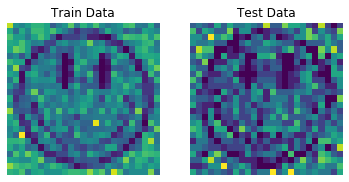

Dataset 2


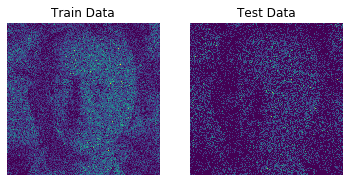

In [5]:
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

#### MADE

$$h(x) = g(b + (W \odot M^W) x)$$
$$ \hat{x} = \text{sigm}(c + (V \odot M^V) h(x))$$

In [6]:
from exp_utils import *
import itertools

class MaskedLinear(nn.Linear):
    def __init__(self, in_feat, out_feat, px_dim, prev_mk):
        super(MaskedLinear, self).__init__(in_feat, out_feat, bias=True)
        self.mask = nn.Parameter(torch.zeros(out_feat, in_feat), requires_grad=False)
        prev_min = prev_mk.min().int()
        self.mk = torch.randint(prev_min, px_dim, (out_feat,))
        for outidx in range(out_feat):
            for inidx in range(in_feat):
                if self.mk[outidx] >= prev_mk[inidx]:
                    self.mask[outidx, inidx] = 1.
                
    def forward(self, x):
        return F.linear(x, self.weight * self.mask, self.bias)


class MaskedLinearOut(nn.Linear):
    def __init__(self, in_feat, out_feat, px_dim, prev_mk):
        super(MaskedLinearOut, self).__init__(in_feat, out_feat, bias=True)
        self.mask = nn.Parameter(torch.zeros(out_feat, in_feat), requires_grad=False)
        self.mk = (torch.arange(px_dim)+1).repeat_interleave(out_feat // px_dim)
        for outidx in range(out_feat):
            for inidx in range(in_feat):
                if self.mk[outidx] > prev_mk[inidx]:
                    self.mask[outidx, inidx] = 1.
                
    def forward(self, x):
        return F.linear(x, self.weight * self.mask, self.bias)

class Made(nn.Module):
    def __init__(self, px_dim, hidden=[512, 512, 512], cats=25):
        super(Made, self).__init__()
        self.cats = cats
        self.px_dim = px_dim
        layers = []
        dims = [px_dim*cats] + hidden
        prev_mk = (torch.arange(px_dim)+1).repeat_interleave(cats) 
        for idx in range(len(dims)-1):
            layers.append(MaskedLinear(dims[idx], dims[idx+1], px_dim, prev_mk))
            prev_mk = layers[-1].mk
#             layers.append(nn.Dropout())
            layers.append(nn.ReLU())
        layers.append(MaskedLinearOut(dims[-1], dims[0], px_dim, prev_mk))
        self.sequential = nn.Sequential(*layers)
        self.loss_func = nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, x):
        bs = x.shape[0]
        x = F.one_hot(x.long(), self.cats)
        x = x.reshape(bs, -1)
        logits = self.sequential(x.float())
        logits = torch.stack(logits.split(self.cats, dim=1), dim=1)
        logits = logits.permute(0, 2, 1)
        return logits
        
    def loss_function(self, preds, targets):
        return self.loss_func(preds, targets).sum(dim=1).mean(dim=0)

    @property
    def probs(self):
        self.eval()
        with torch.no_grad():
            pairs = torch.tensor(list(itertools.product(range(self.cats), range(self.cats))))
            if next(self.parameters()).is_cuda:
                pairs = pairs.cuda()
            logits = self(pairs)
            log_sm = F.log_softmax(logits, dim=1)
            log_probs = torch.gather(log_sm, 1, pairs[:, None, :])
            log_probs = log_probs.squeeze()
            probs_vec = log_probs.sum(dim=1).exp()
            return probs_vec.detach().view(self.cats, self.cats)

In [7]:
def q2_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """

    """ YOUR CODE HERE """
    DEVICE = torch.device('cuda')
    train_loader, test_loader = get_loaders(train_data, test_data, bs=128)
    model = Made(train_loader.dataset.shape[1], [100, 100], d).to(DEVICE)
    adam_optim = torch.optim.Adam
    nll_train, nll_test = training(
        train_loader, test_loader,
        model, adam_optim, learn_rate=0.001, device=DEVICE, epochs=20)
    return nll_train, nll_test, model.probs.cpu().numpy()

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Epoch 0 loss train: 6.4505157470703125, test: 6.4255146980285645
Epoch 1 loss train: 6.42885684967041, test: 6.413599967956543
Epoch 2 loss train: 6.392943382263184, test: 6.396378517150879
Epoch 3 loss train: 6.383094310760498, test: 6.386401653289795
Epoch 4 loss train: 6.366786479949951, test: 6.379965305328369
Epoch 5 loss train: 6.351694107055664, test: 6.3763837814331055
Epoch 6 loss train: 6.298683166503906, test: 6.3746490478515625
Epoch 7 loss train: 6.297740936279297, test: 6.371640205383301
Epoch 8 loss train: 6.394125461578369, test: 6.3703813552856445
Epoch 9 loss train: 6.348771572113037, test: 6.372004985809326
Epoch 10 loss train: 6.295376777648926, test: 6.371882915496826
Epoch 11 loss train: 6.310840606689453, test: 6.367859840393066
Epoch 12 loss train: 6.387014389038086, test: 6.369379997253418
Epoch 13 loss train: 6.308111190795898, test: 6.368919849395752
Epoch 14 loss train: 6.343539714813232, test: 6.369686603546143
Epoch 15 loss train: 6.369790077209473, test: 

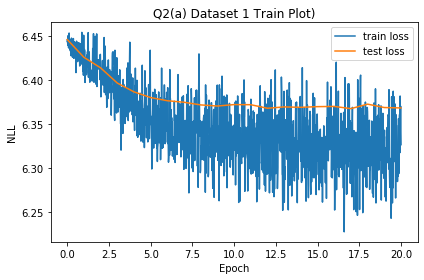

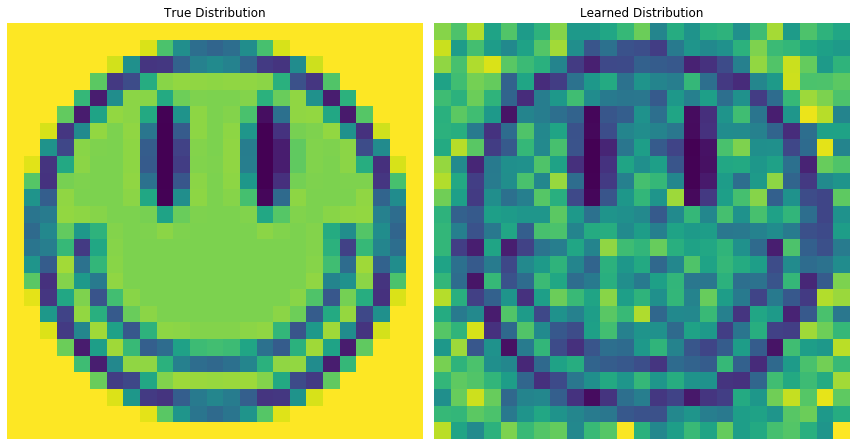

In [8]:
q2_save_results(1, 'a', q2_a)

Epoch 0 loss train: 10.574117660522461, test: 10.550928115844727
Epoch 1 loss train: 10.583261489868164, test: 10.544137001037598
Epoch 2 loss train: 10.544200897216797, test: 10.535846710205078
Epoch 3 loss train: 10.526054382324219, test: 10.53547191619873
Epoch 4 loss train: 10.443198204040527, test: 10.54019546508789
Epoch 5 loss train: 10.485157012939453, test: 10.545464515686035
Epoch 6 loss train: 10.495737075805664, test: 10.549508094787598
Epoch 7 loss train: 10.58787727355957, test: 10.554844856262207
Epoch 8 loss train: 10.463451385498047, test: 10.562461853027344
Epoch 9 loss train: 10.504486083984375, test: 10.565324783325195
Epoch 10 loss train: 10.47984504699707, test: 10.572127342224121
Epoch 11 loss train: 10.522500991821289, test: 10.571674346923828
Epoch 12 loss train: 10.462909698486328, test: 10.577286720275879
Epoch 13 loss train: 10.428237915039062, test: 10.58258056640625
Epoch 14 loss train: 10.441298484802246, test: 10.582074165344238
Epoch 15 loss train: 10.4

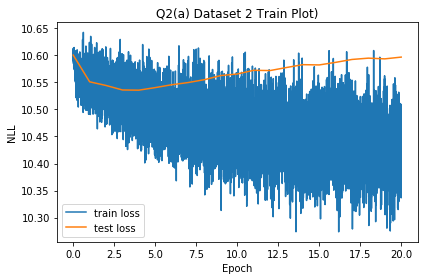

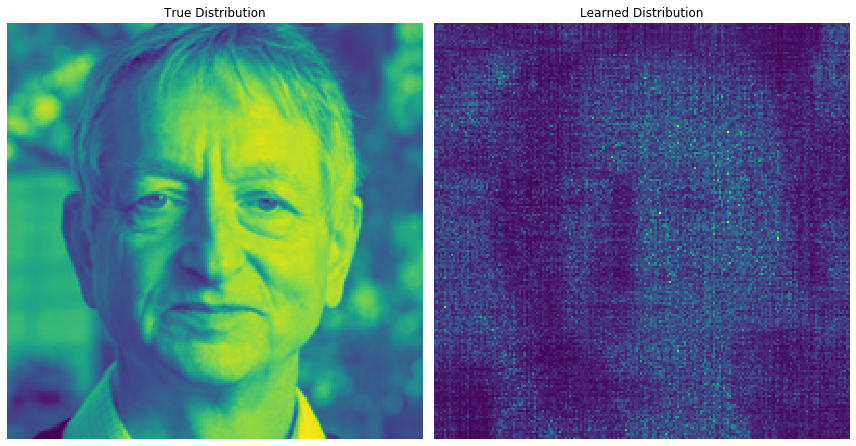

In [9]:
q2_save_results(2, 'a', q2_a)